In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

(200, 200)

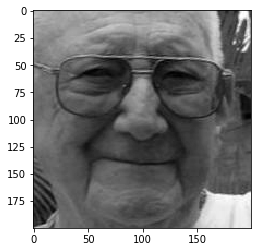

In [2]:
# try to read and write an image with open cv
image = cv2.imread('UTKFace/101_0_0_20170112213500903.jpg.chip.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('UTKFace/foo.jpg', image_gray)
plt.imshow(image_gray, cmap=plt.get_cmap('gray'))
image_gray.shape

### See how many images we have in each category

In [2]:
chart = [0 for x in range(11)]
file_list = os.listdir('UTKFace')
for f in file_list:
    split_f = f.split('_')
    index = int(split_f[0],10)
    if index >= 0 and index <= 2:
        index = 0 # use 0 to represent 0-2
    elif index >= 3 and index <= 12:
        index = 1 # use 1 to represent 3-12
    elif index >= 13 and index <= 19:
        index = 2 # use 2 to represent 13-19
    elif index >= 20 and index <= 29:
        index = 3 # use 3 to represent 20-29
    elif index >= 30 and index <= 39:
        index = 4 # use 4 to represent 30-39
    if index >= 40 and index <= 49:
        index = 5 # use 5 to represent 40-49
    elif index >= 50 and index <= 59:
        index = 6 # use 6 to represent 50-59
    elif index >= 60 and index <= 69:
        index = 7
    elif index >= 70 and index <= 79:
        index = 8
    elif index >= 80 and index <= 89:
        index = 9
    elif index >= 90:
        index = 10

    chart[index] += 1
# display number of image we have for each age
for i in range(len(chart)):
    print(i, ":", chart[i])

0 : 1605
1 : 1808
2 : 1180
3 : 7344
4 : 4537
5 : 2245
6 : 2299
7 : 1318
8 : 699
9 : 504
10 : 169


### Load Data

In [3]:
batch_size = 32
num_workers = 1

# NOTE we can change the input channel from 3 to 1 here
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])
train_data = torchvision.datasets.ImageFolder('new_UTKFace/train', transform=transform)
val_data = torchvision.datasets.ImageFolder('new_UTKFace/validation', transform=transform)
test_data = torchvision.datasets.ImageFolder('new_UTKFace/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(len(train_loader), len(val_loader), len(test_loader))

519 112 111


In [4]:
# Check shape
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)

training: torch.Size([32, 1, 128, 128]) torch.Size([32])


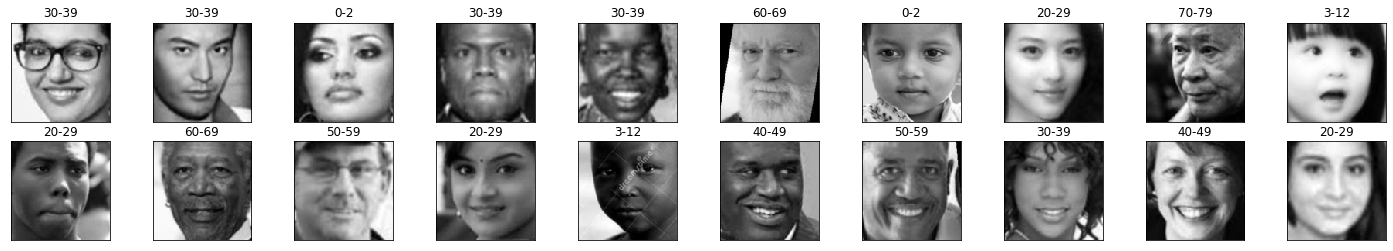

In [7]:
# Get our age group names
age_group = os.listdir("new_UTKFace/test")
# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images = images.squeeze() # (128,128,1) -> (128,128)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap=plt.get_cmap('gray'))
    ax.set_title(age_group[labels[idx]])

### Define our model

In [4]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = "AgeNet"
        # input layer is 1*128*128
        self.conv1 = nn.Conv2d(1, 5, 5, stride = 1, padding = 2) # output layer is 5*64*64
        self.pool1 = nn.MaxPool2d(4, 4) # output layer is 5*32*32
        self.conv2 = nn.Conv2d(5, 10, 5, stride = 1, padding = 2) # output layer is 10*32*32
        self.pool2 = nn.MaxPool2d(2, 2)  # output layer is 10*16*16
        self.conv3 = nn.Conv2d(10, 20, 5, stride = 1, padding = 2) # output layer is 20*16*16
        self.fc1 = nn.Linear(20*16*16, 128) # outputing 128
        self.fc2 = nn.Linear(128, 11)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
# function that calculates the accuracy
def get_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# function that gets the validation loss
def get_val_loss(model, criterion, val_loader):
    total_loss = 0
    total = 0
    for imgs, labels in iter(val_loader):
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)             # forward pass
        prob = F.softmax(output, dim=1)
        loss = criterion(output, labels) # compute the total loss
        total_loss += loss.item()
        total += imgs.shape[0]
    return total_loss / total

# function to train the model
def train(model, train_data, batch_size=32, lr=0.01, num_epochs=1, is_overfit=False):
#     torch.manual_seed(2) # set the random seed
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    if is_overfit:
        overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss() # use cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr) # use adam optimizer

    iters, train_acc, train_loss, val_acc, val_loss = [], [], [], [], []
    best_val_loss = 99999999

    # training
    print("training now...")
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            output = model(imgs)             # forward pass
            prob = F.softmax(output, dim=1)
            loss = criterion(output, labels) # compute the total loss
            loss = loss.float()
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        this_train_loss = float(loss)/batch_size
        train_loss.append(this_train_loss)    # compute *average* loss
        this_val_loss = get_val_loss(model, criterion, val_loader)
        val_loss.append(this_val_loss)
        
        if is_overfit:
            training_accuracy = get_accuracy(model, overfit_loader, batch_size)
            train_acc.append(training_accuracy)
            validation_accuracy = get_accuracy(model, overfit_loader, batch_size)
            val_acc.append(validation_accuracy)
        else:
            training_accuracy = get_accuracy(model, train_loader, batch_size)
            train_acc.append(training_accuracy) # compute training accuracy
            validation_accuracy = get_accuracy(model, val_loader, batch_size)
            val_acc.append(validation_accuracy)
        
        if this_val_loss < best_val_loss: # update best validation loss
            best_val_loss = this_val_loss
            torch.save(model.state_dict(), 'models/model8.pth') # save the best model
        
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, training_accuracy, validation_accuracy))
#         print("Epoch {} - Training Loss: {}, Validation Loss: {}".format(
#             epoch, this_train_loss, this_val_loss))
        n += 1

    # plotting
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
#     print("Final Training Loss: {}".format(train_acc[-1]))
#     print("Final Validation Loss: {}".format(val_acc[-1]))

### Train on different params

In [6]:
use_cuda = torch.cuda.is_available()

In [9]:
model = AgeNet()
# use_cuda = 0
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=30)

training now...


KeyboardInterrupt: 

In [ ]:
model1 = AgeNet()
# use_cuda = 0
if use_cuda:
    model1 = model1.cuda()
train(model1, train_data, batch_size=32, lr=0.0001, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.32166736943557617, Validation Accuracy: 0.32321528948847666
Epoch 1 - Training Accuracy: 0.36292994397927836, Validation Accuracy: 0.3625632377740304
Epoch 2 - Training Accuracy: 0.4137702548039275, Validation Accuracy: 0.40978077571669475
Epoch 3 - Training Accuracy: 0.4317209806638154, Validation Accuracy: 0.42242833052276557
Epoch 4 - Training Accuracy: 0.45178001325221373, Validation Accuracy: 0.4418212478920742
Epoch 5 - Training Accuracy: 0.45858683211854706, Validation Accuracy: 0.4457560427206296
Epoch 6 - Training Accuracy: 0.46497198963917835, Validation Accuracy: 0.44435075885328834
Epoch 7 - Training Accuracy: 0.464490090958376, Validation Accuracy: 0.45165823496346263
Epoch 8 - Training Accuracy: 0.4686464670802964, Validation Accuracy: 0.44997189432265317
Epoch 9 - Training Accuracy: 0.48057345943015484, Validation Accuracy: 0.46149522203485105
Epoch 10 - Training Accuracy: 0.49527136919462683, Validation Accuracy: 0.47779651

In [10]:
model5 = AgeNet()
# use_cuda = 0
if use_cuda:
    model5 = model2.cuda()
train(model5, train_data, batch_size=32, lr=0.0005, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.3937112222155292, Validation Accuracy: 0.3898257448004497
Epoch 1 - Training Accuracy: 0.44117824227456176, Validation Accuracy: 0.433389544688027
Epoch 2 - Training Accuracy: 0.4752725739413288, Validation Accuracy: 0.4575604272062957
Epoch 3 - Training Accuracy: 0.4843081742063731, Validation Accuracy: 0.45812254075323217
Epoch 4 - Training Accuracy: 0.5038250707788687, Validation Accuracy: 0.4645868465430017
Epoch 5 - Training Accuracy: 0.5370158424191314, Validation Accuracy: 0.485947161326588
Epoch 6 - Training Accuracy: 0.5424974399132583, Validation Accuracy: 0.4772344013490725
Epoch 7 - Training Accuracy: 0.5541232455876152, Validation Accuracy: 0.4831365935919056
Epoch 8 - Training Accuracy: 0.5940605987591109, Validation Accuracy: 0.491849353569421
Epoch 9 - Training Accuracy: 0.6095415938798867, Validation Accuracy: 0.4744238336143901
Epoch 10 - Training Accuracy: 0.6170712607674237, Validation Accuracy: 0.4724564362001124
Epoch

KeyboardInterrupt: 

In [12]:
model6 = AgeNet()
# use_cuda = 0
if use_cuda:
    model6 = model6.cuda()
train(model6, train_data, batch_size=32, lr=0.01, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.3416059273537739, Validation Accuracy: 0.33839235525576167
Epoch 1 - Training Accuracy: 0.36292994397927836, Validation Accuracy: 0.35694210230466555
Epoch 2 - Training Accuracy: 0.3785916511053551, Validation Accuracy: 0.37155705452501403
Epoch 3 - Training Accuracy: 0.4294921992651045, Validation Accuracy: 0.41174817313097245
Epoch 4 - Training Accuracy: 0.4273838925365942, Validation Accuracy: 0.40191118605958404
Epoch 5 - Training Accuracy: 0.4445515330401783, Validation Accuracy: 0.4196177627880832
Epoch 6 - Training Accuracy: 0.4694897897717005, Validation Accuracy: 0.42411467116357504
Epoch 7 - Training Accuracy: 0.4932232998012168, Validation Accuracy: 0.44013490725126475
Epoch 8 - Training Accuracy: 0.4694897897717005, Validation Accuracy: 0.40893760539629004


KeyboardInterrupt: 

## The Best Model we have
This one has the highest validation accuracy

And we saved the epoch with the highest validation accuracy

training now...
Epoch 0 - Training Accuracy: 0.4449129570507801, Validation Accuracy: 0.43816750983698705
Epoch 1 - Training Accuracy: 0.46979097644720197, Validation Accuracy: 0.4617762788083193
Epoch 2 - Training Accuracy: 0.5096680922835973, Validation Accuracy: 0.48538504777965147
Epoch 3 - Training Accuracy: 0.5371965544244323, Validation Accuracy: 0.5084317032040472
Epoch 4 - Training Accuracy: 0.547135714715981, Validation Accuracy: 0.49353569421023047
Epoch 5 - Training Accuracy: 0.5836395397867599, Validation Accuracy: 0.5118043844856661
Epoch 6 - Training Accuracy: 0.6100234925606891, Validation Accuracy: 0.508150646430579
Epoch 7 - Training Accuracy: 0.6402626347810373, Validation Accuracy: 0.4963462619449129
Epoch 8 - Training Accuracy: 0.6514065417745919, Validation Accuracy: 0.48369870713884205
Epoch 9 - Training Accuracy: 0.6777302572134208, Validation Accuracy: 0.4822934232715008
Epoch 10 - Training Accuracy: 0.7386904403349196, Validation Accuracy: 0.4741427768409219
E

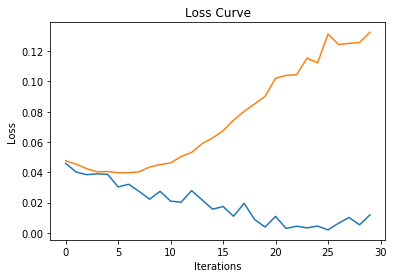

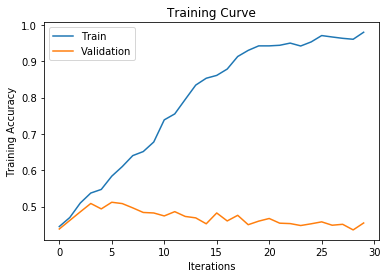

Final Training Loss: 0.980001204746702
Final Validation Loss: 0.4547498594716133


In [10]:
model8 = AgeNet()
# use_cuda = 0
if use_cuda:
    model8 = model8.cuda()
train(model7, train_data, batch_size=32, lr=0.001, num_epochs=30)

### Test

In [7]:
# Get test accuracy 
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model8.pth'))
final_model.cuda().eval()

test_accuracy = get_accuracy(final_model, test_loader, batch_size)
test_accuracy

0.48689771766694845

In [8]:
# List our age groups
age_group = os.listdir("new_UTKFace/test")
age_group

['0-2',
 '13-19',
 '20-29',
 '3-12',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80-89',
 '90+']

tensor([1.4892e-09, 8.4302e-03, 6.8127e-01, 8.7951e-06, 2.1608e-01, 9.2387e-02,
        1.7578e-03, 5.9626e-05, 1.4637e-05, 1.2341e-07, 1.1419e-07],
       grad_fn=<SelectBackward>)
Predicted Age Group: 20-29
Actual Age Group: 20-29


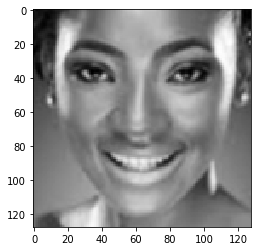

In [11]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model8.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", age_group[pred[0].item()])
print("Actual Age Group:", age_group[labels[0].item()])

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

### Detailed validation accuracy for each group

In [15]:
# function that calculates detailed accuracies in each category
def get_detailed_accuracy(model, loader, batch_size):
    correct = [0 for x in range(11)]
    total = [0 for x in range(11)]
    result = [0 for x in range(11)]
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        pred = prob.max(1, keepdim=True)[1]
        
        for i in range(imgs.shape[0]):
            if labels[i] == 0:
                correct[0] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[0] += 1
            elif labels[i] == 1:
                correct[1] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[1] += 1
            elif labels[i] == 2:
                correct[2] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[2] += 1
            elif labels[i] == 3:
                correct[3] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[3] += 1
            elif labels[i] == 4:
                correct[4] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[4] += 1
            elif labels[i] == 5:
                correct[5] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[5] += 1
            elif labels[i] == 6:
                correct[6] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[6] += 1
            elif labels[i] == 7:
                correct[7] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[7] += 1
            elif labels[i] == 8:
                correct[8] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[8] += 1
            elif labels[i] == 9:
                correct[9] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[9] += 1
            elif labels[i] == 10:
                correct[10] += pred[i].eq(labels[i].view_as(pred[i])).item()
                total[10] += 1
            
    for i in range(11):
#         print(correct[i], total[i])
        result[i] = correct[i]/total[i]
    
    return result

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model8.pth'))
final_model.eval()

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
result = get_detailed_accuracy(final_model, val_loader, batch_size)
for i in range(len(result)):
    print(age_group[i], ":", result[i])

0-2 : 0.8672199170124482
13-19 : 0.1864406779661017
20-29 : 0.7604355716878403
3-12 : 0.6568265682656826
30-39 : 0.17474302496328928
40-49 : 0.32344213649851633
50-59 : 0.4405797101449275
60-69 : 0.3181818181818182
70-79 : 0.08571428571428572
80-89 : 0.39473684210526316
90+ : 0.4


### Less Restricted Accuracy

In [8]:
# function that calculates the accuracy
def get_less_restricted_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        
        # changing them for easier "math" later
        for i in range(labels.shape[0]):
            if labels[i] == 3:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 2
            elif labels[i] == 2:
                labels[i] = 3
            
            if pred[i] == 3:
                pred[i] = 1
            elif pred[i] == 1:
                pred[i] = 2
            elif pred[i] == 2:
                pred[i] = 3
        
        for i in range(imgs.shape[0]):
            if abs(pred[i] - labels[i].view_as(pred[i])) <= 1:
                correct += 1
                
        total += imgs.shape[0]
    return correct / total

In [13]:
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model8.pth'))
final_model.cuda().eval()

less_restricted_test_accuracy = get_less_restricted_accuracy(final_model, test_loader, batch_size)
less_restricted_test_accuracy

0.8362919132149902

In [11]:
less_restricted_val_accuracy = get_less_restricted_accuracy(final_model, val_loader, batch_size)
less_restricted_val_accuracy

0.8482293423271501

### Load my own data

In [29]:
import cv2
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])
my_data = torchvision.datasets.ImageFolder('my_data', transform=transform)
my_loader = torch.utils.data.DataLoader(my_data, batch_size=1)
myiter = iter(my_loader)
imgs, labels = myiter.next()

# load my final model
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model8.pth'))
final_model.eval()

AgeNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=5120, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

(1, 128, 128)


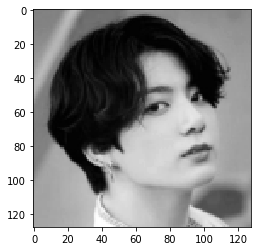

In [30]:
# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.reshape(-1,128,128)
print(imgs.shape)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

### Visualize filters and feature maps

In [31]:
# function for getting the feature maps
activation = {}
def get_activation(name):
    def hook(final_model, input, output):
        activation[name] = output.detach()
    return hook

conv1 size: torch.Size([5, 1, 5, 5])


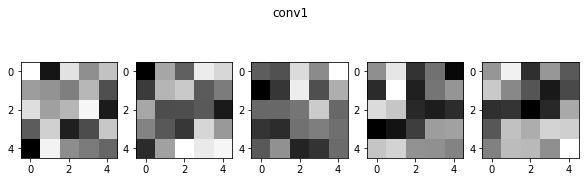

In [32]:
kernels = final_model.conv1.weight.detach()
print("conv1 size:", kernels.shape)
kernels = kernels.cpu()
fig = plt.figure(figsize=(10,3))
fig.suptitle("conv1")
fig.tight_layout()
for idx in range(kernels.size(0)):
    fig.add_subplot(1, 5, idx+1)
    plt.imshow(kernels[idx][0], cmap=plt.get_cmap('gray'))

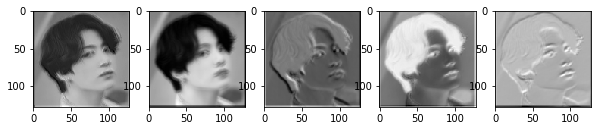

In [33]:
myiter = iter(my_loader)
imgs, labels = myiter.next()
final_model.conv1.register_forward_hook(get_activation('conv1'))
output = final_model(imgs)
act = activation['conv1'].squeeze()

# fig, axarr = plt.subplots(act.size(0))
fig = plt.figure(figsize=(10,3))
for idx in range(act.size(0)):
    fig.add_subplot(1, 5, idx+1)
    plt.imshow(act[idx], cmap=plt.get_cmap('gray'))

conv2 size: torch.Size([10, 5, 5, 5])


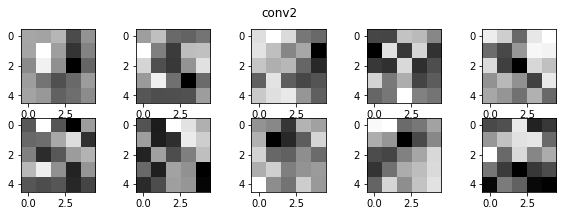

In [34]:
kernels = final_model.conv2.weight.detach()
print("conv2 size:", kernels.shape)
kernels = kernels.cpu()
fig = plt.figure(figsize=(10,3))
fig.suptitle("conv2")
fig.tight_layout()
for idx in range(kernels.size(0)):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(kernels[idx][0], cmap=plt.get_cmap('gray'))

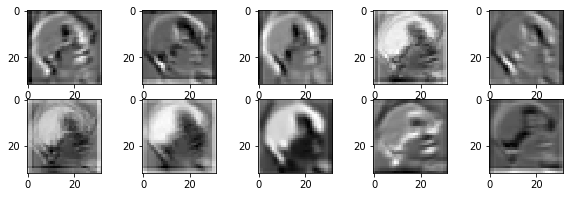

In [35]:
final_model.conv2.register_forward_hook(get_activation('conv2'))
output = final_model(imgs)
act = activation['conv2'].squeeze()

fig = plt.figure(figsize=(10,3))
for idx in range(act.size(0)):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(act[idx], cmap=plt.get_cmap('gray'))

conv3 size: torch.Size([20, 10, 5, 5])


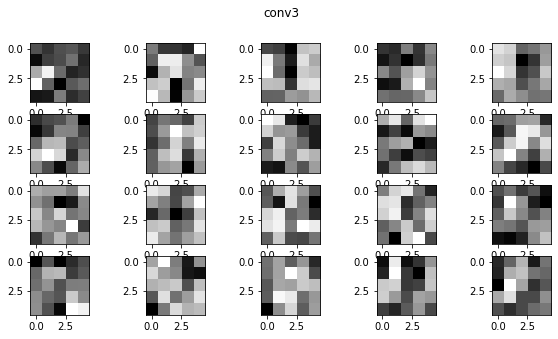

In [36]:
kernels = final_model.conv3.weight.detach()
print("conv3 size:", kernels.shape)
kernels = kernels.cpu()
fig = plt.figure(figsize=(10,5))
fig.suptitle("conv3")
fig.tight_layout()
for idx in range(kernels.size(0)):
    fig.add_subplot(4, 5, idx+1)
    plt.imshow(kernels[idx][0], cmap=plt.get_cmap('gray'))

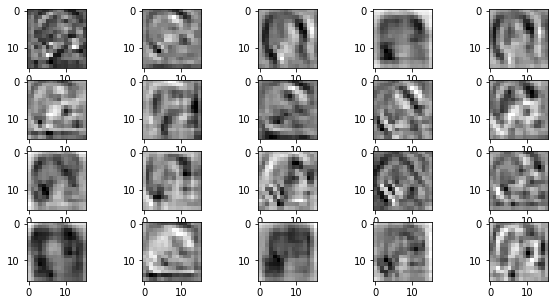

In [37]:
final_model.conv3.register_forward_hook(get_activation('conv3'))
output = final_model(imgs)
act = activation['conv3'].squeeze()

fig = plt.figure(figsize=(10,5))
for idx in range(act.size(0)):
    fig.add_subplot(4, 5, idx+1)
    plt.imshow(act[idx], cmap=plt.get_cmap('gray'))

fc1 size: torch.Size([1, 128])


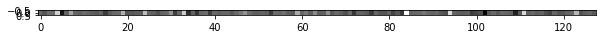

In [38]:
final_model.fc1.register_forward_hook(get_activation('fc1'))
output = final_model(imgs)
act = activation['fc1']
plt.figure(figsize=(10,5))

print("fc1 size:", act.shape)
plt.imshow(act, cmap=plt.get_cmap('gray'))

fc2 size: torch.Size([1, 11])
tensor([[ 0.2542,  1.3736,  3.6529,  0.3690,  0.5988, -2.4273, -2.2294, -3.9626,
         -3.7999, -4.2673, -3.8576]])


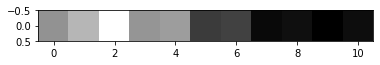

In [39]:
final_model.fc2.register_forward_hook(get_activation('fc2'))
output = final_model(imgs)
act = activation['fc2']

print("fc2 size:", act.shape)
plt.imshow(act, cmap=plt.get_cmap('gray'))
print(act)

In [40]:
# see what my model's prediction is
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]

print("Actual Age Group:", age_group[labels[0].item()])
print("Predicted Age Group:", age_group[pred[0].item()])

Actual Age Group: 20-29
Predicted Age Group: 20-29
